# Neutron burst calculation
The following is a notebook that can compute the final abundances of a network of species of neutron burst reactions. The mathematics follows the solution to the linar acyclic reaction network worked out in Davila and Meyer 2024.

The neutron burst is a type of explosive nucleosynthesis that occurs in the bottom of the helium shell. It is triggered when the shock heats the material increasing the rate of the $^{22}$Ne($\alpha$,n)$^{25}$Mg reaction and thus causing a sharp, but breif spike in the neutron density. 

The neutron burst is essentially an acyclic, linear network and thus a graph theory approach can be invoked in which the abundance of species $i$ that flows to species $j$ across some path $P$ is given by:

\begin{gather}
G_{ij}^P=\frac{(\sigma \tau)^{N-1}}{(N-1)!}\sum_{n=0}^\infty \bar{h}_n(\sigma_1,\sigma_2,...,\sigma_N)\frac{(-\tau)^n}{n!}
\end{gather}

Where the $\bar{h}$ are the complete homogeneous symmetric polynomials. Alternatively, considering $\bar{h}_n(\sigma_1, \sigma_2,...,\sigma_N) = B_n(x_1,x_2,....x_n)$ and the generating function for the bell polynomials is:

\begin{gather}
\exp\Big(\sum_{j=1}^\infty x_j \frac{t^j}{j!}\Big) = \sum_{n=0}^\infty B_n(x_1,...,x_n)\frac{t^n}{n!}
\end{gather}

Then: 

\begin{gather}
G_{ij}^{P}(\tau) = F^{P} \frac{(\sigma \tau)^{N-1}}{(N-1)!} \exp\Big(\sum_{k=1}^\infty x_k \frac{(-\tau)^k}{k!}\Big)
\end{gather}

These results are exact, but written in terms of an infinite sum. For low $\tau$, higher order terms in the sum can be ignored due to the factorial in the denominator, but for high $\tau$ more creative approaches are needed. 

## Simple case

Here we explore a trivial case, where all cross sections are equivalent to demonstrate how the wnpoly python package works in computing the complete symmetric polynomials as well as the bell polynomials. 

For the simple case we consider all reaction cross sections to be identical. In this limit the bell polynomial expression for the $G_{ij}s$ is:

\begin{gather}
G_{ij}(\tau) = \frac{(\sigma \tau)^{N-1}}{(N-1)!}\exp(-\sigma\tau)
\end{gather}
Where $\sigma$ is the geometric mean of the cross sections.

Let's consider the reaction chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}

where 1, 2, 3, and 4 are arbitrary species and 'n' represents neutrons. From above, the abundance of the any species $j$ can be written as:
\begin{gather}
Y_4(\tau) = \sum_{i\leq 4} G_{i4}(\tau) Y_i(0) = G_{14}(\tau) Y_1(0) + G_{24}(\tau) Y_2(0)+ G_{34}(\tau)Y_3(0) + G_{44}(\tau) Y_4(0)
\end{gather}


To solve this network exactly we have the coupled differential equations:
\begin{gather}
\frac{dY_1}{d\tau} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{d\tau} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{d\tau} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{d\tau} = \sigma_{n,3} Y_3 - \sigma_{n,4}Y_4
\end{gather}
where the $\sigma_n$ are the neutron capture cross sections for each species.

We begin by importing the relavent python libraries:

In [53]:
import sys
!{sys.executable} -m pip install --quiet wnpoly
from gslconsts.consts import *
from scipy.integrate import solve_ivp
import numpy as np
import math
import wnpoly as wp
from scipy.stats import gmean
import matplotlib.pyplot as plt

In [54]:
k = GSL_CONST_CGS_BOLTZMANN
N_A = GSL_CONST_NUM_AVOGADRO
m_n = GSL_CONST_CGS_MASS_NEUTRON

Next, we define two functions. The function Y will be used to solve the system of differential equations exactly, and the G is used to compute the relative contributions between species. Both of these equations are general and do not depend on the reaction rates being the same for all reactions and thus will be used throughout the notebook. 

In [55]:
def Y(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

def g(tau, x, sigma, n):
    result = 0 
    for i in range(len(x)):
        result += x[i] * (-tau)**i / math.factorial(i)
    return (sigma*tau)**(n-1) * np.exp(result) / math.factorial(n-1)

Next we define the cross sections to be unity and define the initial abundances of the species. It is important to note that the initial abundance array should be the length of the cross section array, since the last cross section represents the flow out of the last species. We also set the abundance of the first species to one:

In [56]:
sigs = [2,2,2,2]
m = len(sigs)

ys = np.zeros(m)
ys[0] = 1
ys[1] = 1

Now with the cross sections defined, we can begin calculating the complete homogeneous symmetric polynomials and the Bell polynomial coefficients using [wnpoly](https://wnpoly.readthedocs.io/en/latest/). We begin by creating an instance of complete homogenous symmetric polynomials and compute them with our cross sections:

In [57]:
s = wp.symm.Complete()
bell = wp.bell.Bell()

Now, since these are equivalent to the bell polynomials the h_norm can be used to compute the inverse of the bell polynomials which are the $x_j$s in our equation:

We see that the only coefficient that is nonzero is the $x_1$ term, which represents the geometric mean of all the cross sections, $\sigma$. Now we can go about computing the final abundance, $Y_4$, as a function of $\tau$. We do this both by computing the $G_{ij}$s and the exact solution to compare. 

In [58]:
tau = np.linspace(0.01, 10, 100)
g_array = np.zeros((len(tau), m, m))

for t in range(len(tau)):
    for i in range(len(ys)):
        for j in range(len(ys)):
            if j<=i:
                sigs_array = sigs[j:i+1]
                n = len(sigs_array)
                sig = gmean(sigs_array)
                h_norm = s.compute_normalized(sigs_array, 6)
                x = bell.invert(h_norm)
                g_array[t][i,j] = g(tau[t], x, sig, n)

In [59]:
y_final = np.zeros([len(tau), m])
for t in range(len(tau)):
    y_final[t] = np.dot(g_array[t], ys)

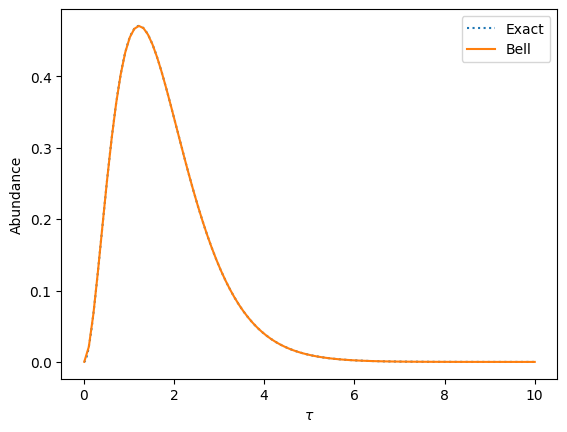

In [60]:
sol = solve_ivp(Y, [0, tau[len(tau)-1]], ys, args=(sigs,), max_step=0.002)
#plot results
plt.plot(sol.t, sol.y[m-1], ':', label='Exact')
plt.plot(tau, y_final[:,3] , label='Bell')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abundance')
plt.show()

## A realistic example: calcium isotopes

A possible candidate for exhibiting neutron burst signatures are the calcium isotopes. This section demonstrates how to use [wnnet](https://wnnet.readthedocs.io/en/latest/) to compute the realistic reaction cross sections in a neutron burst environment and apply our acyclic network calculation to delve further into understanding this process.

We begin by importing the necessary libraries and obtaining the nuclear network xml file:

In [61]:
import os, io, requests
from lxml import etree 

!{sys.executable} -m pip install --quiet wnnet
!{sys.executable} -m pip install --quiet wnutils
import wnnet as wn
import wnutils.xml as wx


net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

Next, we define a function to pull the solar isotopic data from a solar data xml file:

In [62]:
def get_solar_isotopes(solar_xml, isotopes):
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    abunds = []
    names = []

    for isotope in isotopes:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        if s_tup in x_solar:
            names.append(isotope)
            abunds.append(x_solar[s_tup] / tup[1])
        else:
            abunds.append(0)
            

    return names, abunds

Next, we define a temperature in $10^9$K to be used to compute the reaction rates. The "induced_nuc_xpath" selects a subset of the nuclei in the network. For our purposes in the neutron burst we must include neutrons (i.e. a=1 and z=0), but the additional xpath expression after "or" can be modified for any set of isotopes (e.g. z=40 and a-z >= 54 and a-z <= 60 would select zirconium isotopes between $^{94}$Zr and $^{100}$Zr). The "induced_reac_xpath" selects a subset of reactions and should not be changed as it selects only (n,$\gamma$) reactions.  

In [63]:
t9 = 10

induced_nuc_xpath = "[(a=1 and z=0) or (z = 20 and a - z >= 20 and a - z <= 30)]"
induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
reacs = net.compute_rates(t9, nuc_xpath = induced_nuc_xpath, reac_xpath = induced_reac_xpath)
rates = []
for key, values in list(reacs.items()):
    rates.append(values[0])
    print('reaction :', key, ';', 'Forward rate :', '{:.2e}'.format(values[0]))

reaction : n + ca44 -> ca45 + gamma ; Forward rate : 9.69e+05
reaction : n + ca43 -> ca44 + gamma ; Forward rate : 2.00e+06
reaction : n + ca46 -> ca47 + gamma ; Forward rate : 5.72e+05
reaction : n + ca42 -> ca43 + gamma ; Forward rate : 1.71e+06
reaction : n + ca45 -> ca46 + gamma ; Forward rate : 8.22e+05
reaction : n + ca47 -> ca48 + gamma ; Forward rate : 4.05e+05
reaction : n + ca49 -> ca50 + gamma ; Forward rate : 1.37e+05
reaction : n + ca40 -> ca41 + gamma ; Forward rate : 1.70e+06
reaction : n + ca41 -> ca42 + gamma ; Forward rate : 2.17e+06
reaction : n + ca48 -> ca49 + gamma ; Forward rate : 1.52e+05


The reaction dictionary returned by wnnet does not order the reactions by increasing neutron number, so next we create an ordered array of the cross sections along the path in the order of the neutron burst pathway:

In [64]:
species = ['ca40','ca41','ca42','ca43','ca44','ca45','ca46','ca47','ca48']
ordered_dict = {}

for sp in species:
    for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
        if sp in value.reactants:
            ordered_dict[sp] = reacs[key][0]

Now that we have obtained the rates, we can get the cross sections by noting:
\begin{gather}
r(T) = N_A <\sigma v>(T)
\end{gather}
and the thermal velocity is given by:
\begin{gather}
v_T = \sqrt{\frac{2k_BT}{m_n}}
\end{gather}
which represents the most probable velocity in a Maxwell-Boltzmann distribution. We then compute the cross sections:

In [118]:
T = t9 * 10**9
v_T = np.sqrt((2*k*T)/m_n)

#sigs = {}
sigs_array = []
for key, value in ordered_dict.items():
    sigs_array.append(1000*value/(v_T*N_A*wn.consts.GSL_CONST_CGSM_BARN))

Since the cross sections differ by orders of magnitude, we require additional tools for the solution to the acyclic reaction network. A discussion of these different methods can be found with the aid of this [osf page](https://github.com/lucaswalls18/linear_acyclic_tools). The method done here utilizes the complex shift for Laplace transforms. First, we define a couple of functions that give the relative contributions: 

In [113]:
from scipy.special import gammaln
def get_fbar(sigma):
    sig_max = max(sigma)
    return [(sig_max - sigs)/sig_max for sigs in sigma]

def G_bell(tau, sigma, N):
    f_bar = get_fbar(sigma)
    m = len(sigma)
    sig = gmean(sigma)
    h = s.compute_normalized(f_bar, N)
    x = bell.invert(h)
    result = 0 
    for i in range(N):
        result += x[i] * np.exp(i*np.log(max(sigma)*tau)-gammaln(i+1))
    return np.exp((m-1)*np.log(sig*tau) - gammaln(m) - max(sigma)*tau + result)

Next, we obtain the solar abundances:

In [94]:
solar_xml = wx.Xml(
    io.BytesIO(requests.get("https://osf.io/w8ktc/download").content)
)
ca_names, ys = get_solar_isotopes(solar_xml, species)
ys /= np.sum(ys)

Now, we compute the final abundances using the complex shift solution for the linear acyclic reaction network.

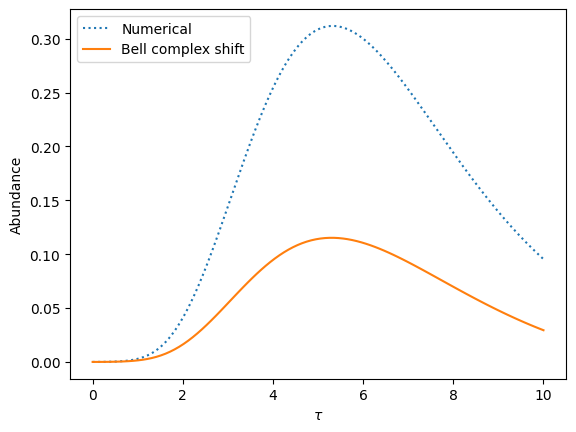

In [137]:
tau = np.linspace(0.001, 10, 100)

g_bell_array = np.zeros((len(tau), len(sigs_array), len(sigs_array)))
for t in range(len(tau)):
    for i in range(len(ys)):
        for j in range(len(ys)):
            if j<=i:
                sig_array = sigs_array[j:i+1]
                g_bell_array[t][i,j] = G_bell(tau[t], sig_array, 10)
                
y_b_final = np.zeros([len(tau), len(sigs_array)])
for t in range(len(tau)):
    y_b_final[t] = np.dot(g_bell_array[t], ys)

sol = solve_ivp(Y, [0, tau[len(tau)-1]], ys, args=(sigs_array,), max_step=0.02)

#plot results
plt.plot(sol.t, sol.y[7], ':', label='Numerical')
plt.plot(tau, y_b_final[:,7], label = 'Bell complex shift')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel('Abundance')
plt.show()

In [133]:
ys

array([9.69396862e-01, 0.00000000e+00, 6.46810406e-03, 1.35093313e-03,
       2.08780574e-02, 0.00000000e+00, 3.92998728e-05, 0.00000000e+00,
       1.86674396e-03])